In [ ]:
! pip install fasttext
! pip install -U gensim
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
# ! gunzip cc.id.300.bin.gz
! pip install -U symspellpy
! wget https://dumps.wikimedia.org/idwiki/latest/idwiki-latest-pages-articles.xml.bz2
! pip install Sastrawi
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
# ! gunzip cc.id.300.vec.gz
! pip install wordcloud
# ! pip install bpemb

  Using cached https://files.pythonhosted.org/packages/f8/85/e2b368ab6d3528827b147fdb814f8189acc981a4bc2f99ab894650e05c40/fasttext-0.9.2.tar.gz
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3021570 sha256=d6d25abf42d1d078430829751d315b76f0acc94d000c97203cc501d55086c1dd
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)
Requirement already up-to-date: symspellpy in /usr/local/lib/python3.6/dist-packages (6.5.2)
--2020-07-27 11:05:43--  https://dumps.wikimedia.org/idwiki/latest/idwiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611634803 (583M) [application/

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.corpora import WikiCorpus
from urllib.request import urlopen
from collections import Counter
import gzip
import numpy as np

In [ ]:
# lakukan load dataset terlebih dahulu
df_review = pd.read_csv("/content/review.csv")
df_review.head()

ParserError: ignored

In [ ]:
# coba kita perhatikan berapa banyak data yang kita dapatkan
df_review.describe()


,Star
count,63320.000000
mean,3.962066
std,1.573255
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
# coba kita lihat berapa banyak jumlah data untuk tiap rate
df_review["Star"].value_counts()

5    40606
1    11188
4     5118
3     3372
2     3036
Name: Star, dtype: int64

In [ ]:
df_review['Comment'][1000]

'tampilan antarmuka simpel tp keren, ketersediaan barang oke, layanan mantap, favorit!'

In [ ]:
# drop unused column
df_preprocessed = df_review.copy()
df_preprocessed = df_preprocessed.drop(columns=['Date', 'Name'])
df_preprocessed.head()

,Comment,Star
0,Bisa tahu ongkir sebelum beli adalah kenikmata...,5
1,Nice olshop,5
2,"Penggunaan mudah, simpel, gak banyak flash yg ...",5
3,Applikasi beefungsi dg baik dan lancar terimak...,5
4,kenapa skrg lemot sih respon pelanggan,1


Label Encoding

In [ ]:
# label encoding pada Star
# Jika 1-4, maka sentiment negative (label 0)
# Jika 5, maka sentiment positive (label 1)
label = []
for index, row in df_preprocessed.iterrows():
    if row["Star"] == 5:
        label.append(1)
    else:
        label.append(0)

df_preprocessed["label"] = label
df_preprocessed = df_preprocessed.drop(columns=['Star'])
df_preprocessed.head()

,Comment,label
0,Bisa tahu ongkir sebelum beli adalah kenikmata...,1
1,Nice olshop,1
2,"Penggunaan mudah, simpel, gak banyak flash yg ...",1
3,Applikasi beefungsi dg baik dan lancar terimak...,1
4,kenapa skrg lemot sih respon pelanggan,0


In [ ]:
df_preprocessed["label"].value_counts()

1    40606
0    22714
Name: label, dtype: int64

Balancing Dataset

In [ ]:
# balancing dataset
s_1 = df_preprocessed[df_preprocessed['label']==0].sample(25000,replace=True)
s_2 = df_preprocessed[df_preprocessed['label']==1].sample(25000,replace=True)
df_preprocessed = pd.concat([s_1, s_2])

print(df_preprocessed.shape)

print(df_preprocessed['label'].value_counts(normalize=True))

(50000, 2)
1    0.5
0    0.5
Name: label, dtype: float64


In [ ]:
Counter(df_preprocessed["label"])

Counter({0: 25000, 1: 25000})

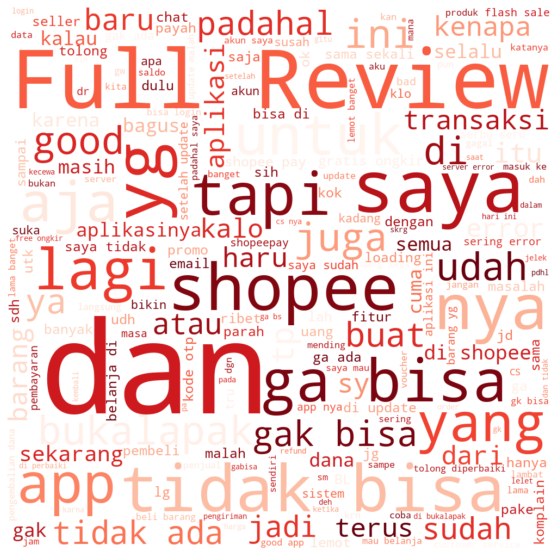

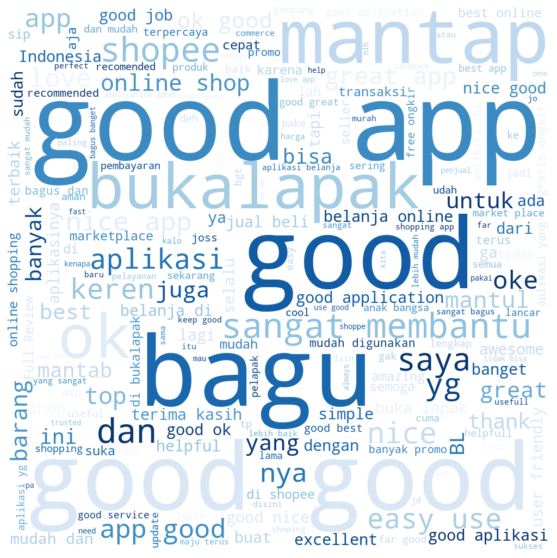

In [ ]:
# wordcloud
from wordcloud import WordCloud

# Polarity == 0 negative
train_s0 = df_preprocessed[df_preprocessed["label"] == 0]
all_text_s0 = ' '.join(word for word in train_s0["Comment"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Polarity == 1 positive
train_s1 = df_preprocessed[df_preprocessed["label"] == 1]
all_text_s1 = ' '.join(word for word in train_s1["Comment"])
wordcloud = WordCloud(width=1000, height=1000, colormap='Blues', background_color='white', mode='RGBA').generate(all_text_s1)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
# create txt file for spell check dictionary
wiki = WikiCorpus("idwiki-latest-pages-articles.xml.bz2", lemmatize=False, dictionary={})

with open("wiki-id-formatted.txt", 'w', encoding="utf8") as output:
     counter = 0
     for text in wiki.get_texts():
         output.write(' '.join(text)+"\n")
         counter = counter + 1
         if counter > 200000: # Hanya mengambil 200,000 artikel pertama dari total artikel sekitar 300,000
             break

In [ ]:

# create dictionary for symspell
from symspellpy import SymSpell

sym_spell = SymSpell()
corpus_path = "wiki-id-formatted.txt"
sym_spell.create_dictionary(corpus_path)

True

In [ ]:
from symspellpy import SymSpell, Verbosity

input_term = "diperbaiko diperbaike perbaiknn"  # misspelling of "apostrophe"
# max edit distance per lookup
# (max_edit_distance_lookup <= max_dictionary_edit_distance)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)

for suggestion in suggestions:
    print(suggestion.term)

diperbaiki diperbaiki perbaikan


In [ ]:
review = []
for index, row in df_preprocessed.iterrows():
    suggestions = sym_spell.lookup_compound(row["Comment"], max_edit_distance=2)
    review.append(suggestions[0].term)
    
df_preprocessed["Comment"] = review
df_preprocessed.head()

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# contoh
kalimat = 'lemot aplikasinya sedih high banget aku fiturnya harus diperbaiki supaya lebih mudah lagi tampilan kurang menarik'
katadasar = stemmer.stem(kalimat)
 
print(katadasar)

In [ ]:
review = []
for index, row in df_preprocessed.iterrows():
    review.append(stemmer.stem(row["Comment"]))
    
df_preprocessed["Comment"] = review
df_preprocessed.head()

In [ ]:
def preprocess_data(text):
    # spell check
    text = sym_spell.lookup_compound(text, max_edit_distance=2)[0].term

    # stemming
    text = stemmer.stem(text)

    return text

WORD EMBEDDING

In [ ]:
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz'))

vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
    values = line.split()
    word = values [0].decode('utf-8')
    vector = np.asarray(values[1:], dtype='float32')
    vocab_and_vectors[word] = vector

In [ ]:
# more imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# how many features should the tokenizer extract
features = 500
tokenizer = Tokenizer(num_words = features)
# fit the tokenizer on our text
tokenizer.fit_on_texts(df_preprocessed["Comment"].tolist())

# get all words that the tokenizer knows
word_index = tokenizer.word_index
print(len(word_index))
# put the tokens in a matrix
X = tokenizer.texts_to_sequences(df_preprocessed["Comment"].tolist())
X = pad_sequences(X)

# prepare the labels
y = df_preprocessed["label"].values

# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=30)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = vocab_and_vectors.get(word)
    # words that cannot be found will be set to 0
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 300, input_length=X.shape[1], weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test), 
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
# predict on a sample text
# jika >= 0.5, sentiment positif
# jika < 0.5, sentiment negatif
sample_positive_review = "Respon Cepat, pelayanan bagus"
sample_negative_review = "pendaftaran buka reksanya lama sekali sudah hampir dua minggu belum selesai juga"

X_pos = tokenizer.texts_to_sequences([preprocess_data(sample_positive_review)])
X_pos = pad_sequences(X_pos, maxlen=X.shape[1])

X_neg = tokenizer.texts_to_sequences([preprocess_data(sample_negative_review)])
X_neg = pad_sequences(X_neg, maxlen=X.shape[1])

pred_pos = model.predict(X_pos)
pred_neg = model.predict(X_neg)

print(pred_pos)
print(pred_neg)

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
pred = model.predict(X_test)

# rubah sigmoid
y_pred = []
for p in pred:
    if p >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
accuracy_score(y_test, y_pred)

In [ ]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp
